In [51]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import seaborn as sns
import pandas as pd
import numpy as np

from typing import Callable

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

from src.clustering import GeneralClustererFinder

# Reading the data

For better clustering exploration I will merge the two labeled data files we currently have and merge them into a 2d series.

Since we cannot meaningfully merge two entries from different repeated experiments, I will use average VALUE of a given compound in an experiment as one dimension.

In [52]:
data_ros1 = pd.read_excel("../data/raw/ROS1_DTT_fanonymised_limited.xlsx")
data_ros2 = pd.read_excel("../data/raw/ROS2_HRP anonymised limited.xlsx")

In [53]:
mean_value_ros1 = data_ros1.groupby("DTT  - compound ID").mean(numeric_only=True)["VALUE"].rename("DTT_VALUE")
mean_value_ros2 = data_ros2.groupby("HRP - compound ID").mean(numeric_only=True)["VALUE"].rename("HRP_VALUE")

ss_dtt = StandardScaler()
ss_hrp = StandardScaler()

mean_value_merged = pd.concat([mean_value_ros1, mean_value_ros2], axis=1).dropna()
mean_value_norm_ros1 = ss_dtt.fit_transform(mean_value_merged["DTT_VALUE"].to_numpy().reshape(-1, 1)).flatten()
mean_value_norm_ros2 = ss_hrp.fit_transform(mean_value_merged["HRP_VALUE"].to_numpy().reshape(-1, 1)).flatten()
mean_value_merged["DTT_VALUE_NORM"] = mean_value_norm_ros1
mean_value_merged["HRP_VALUE_NORM"] = mean_value_norm_ros2
value_series = mean_value_merged[["DTT_VALUE_NORM", "HRP_VALUE_NORM"]].to_numpy()

# Data Clustering Parameters Setup

I will use GeneralClustererFinder on the following three algorithms:
-   Affitiy Propagation
-   KMeans
-   GaussianMixture

In [54]:
RANDOM_STATE = 31
CLUSTERING_CONFIG = [
    {
        "name": "AffinityPropagation",
        "clusterer": AffinityPropagation(),
        "param_grid": ParameterGrid({
            "damping": [0.5, 0.75, 0.9, 0.95, 0.99, 0.995,0.999],
            "random_state": [RANDOM_STATE]
        }),
    },
    {
        "name": "KMeans",
        "clusterer": KMeans(),
        "param_grid": ParameterGrid({
            "n_clusters": range(2, 16),
            "random_state": [RANDOM_STATE]
        }),
    },
    {
        "name": "GaussianMixture",
        "clusterer": GaussianMixture(),
        "param_grid": ParameterGrid({
            "n_components": range(2, 16),
            "random_state": [RANDOM_STATE]
        }),
    }
]

In [55]:
def evaluate_with_metric(data_series: np.array, metric: Callable[[np.array, np.array], float], index: pd.Series) -> pd.DataFrame:
    df = pd.DataFrame(index=index)
    for config in CLUSTERING_CONFIG:
        print(f"==== CLUSTERING WITH {config['name']} ====")
        clusterer_finder = GeneralClustererFinder(
            param_grid=config["param_grid"],
            clusterer=config["clusterer"],
            scoring_function=metric
        )
        clusterer_finder.cluster_data_series(data_series, verbose=True)
        df[f"labels_{config['name']}"] = clusterer_finder.cached_best_prediction
    return df

In [80]:
def summarize_clustering(labelled_df: pd.DataFrame) -> None:
    for config in CLUSTERING_CONFIG:
        print(f"\n==== {config['name']} CLUSTERING RESULT SUMMARY ====\n")
        label_colname = f"labels_{config['name']}"
        cluster_counts = labelled_df[label_colname].value_counts().to_dict()
        for cluster in labelled_df.groupby(label_colname).mean().itertuples():
            print(f"Cluster {cluster.Index}: {cluster_counts[cluster.Index]} compounds")
            print(f"\tMean DTT Value: {cluster.DTT_VALUE}\n\tMean HRP Value: {cluster.HRP_VALUE}")

## Clustering results using Silhouette Score

In [56]:
ss_results = evaluate_with_metric(value_series, metrics.silhouette_score, mean_value_merged.index)

==== CLUSTERING WITH AffinityPropagation ====


d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Params: {'damping': 0.5, 'random_state': 31} | Score: 0.2035033399776069
Params: {'damping': 0.75, 'random_state': 31} | Score: 0.3234497809272515
Params: {'damping': 0.9, 'random_state': 31} | Score: 0.3315186264632525
Params: {'damping': 0.95, 'random_state': 31} | Score: 0.4142369335789901
Params: {'damping': 0.99, 'random_state': 31} | Score: 0.4142369335789901
Params: {'damping': 0.995, 'random_state': 31} | Score: 0.4142369335789901
Params: {'damping': 0.999, 'random_state': 31} | Score: 0.4142369335789901

DONE

Best Score: 0.4142369335789901
Best Params: {'damping': 0.95, 'random_state': 31}
==== CLUSTERING WITH KMeans ====
Params: {'n_clusters': 2, 'random_state': 31} | Score: 0.9649757173076864
Params: {'n_clusters': 3, 'random_state': 31} | Score: 0.9527213882251134
Params: {'n_clusters': 4, 'random_state': 31} | Score: 0.9386907818487996
Params: {'n_clusters': 5, 'random_state': 31} | Score: 0.9382736396590661
Params: {'n_clusters': 6, 'random_state': 31} | Score: 0.4743886

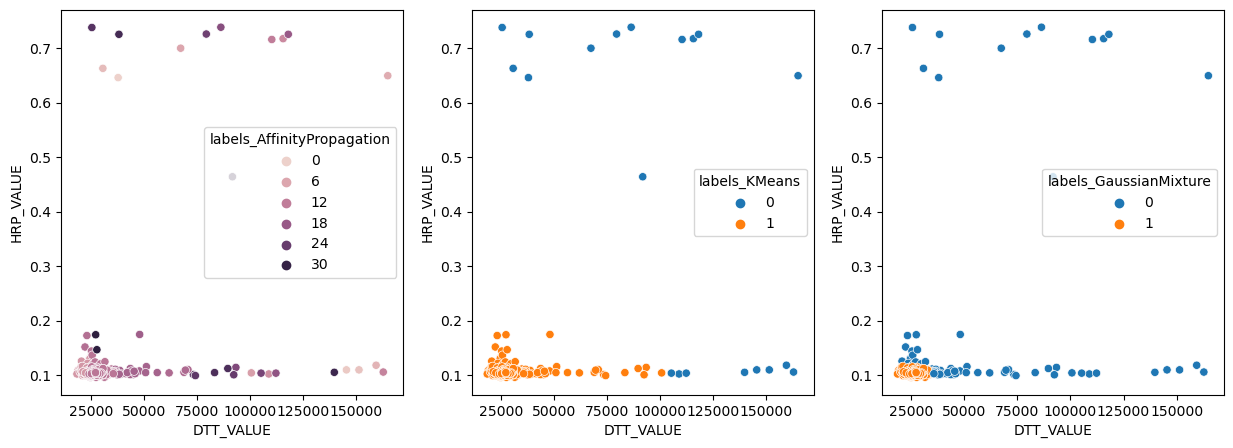

In [57]:
ss_scores_merged = pd.concat([mean_value_merged, ss_results], axis=1)

fig, ax = plt.subplots(1, 3, figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(ss_scores_merged, x="DTT_VALUE", y="HRP_VALUE", hue=f"labels_{config['name']}", ax=subplt)

In [81]:
summarize_clustering(ss_scores_merged)


==== AffinityPropagation CLUSTERING RESULT SUMMARY ====

Cluster 0: 1 compounds
	Mean DTT Value: 37919.0
	Mean HRP Value: 0.646
Cluster 1: 1 compounds
	Mean DTT Value: 145488.5
	Mean HRP Value: 0.1095
Cluster 2: 1 compounds
	Mean DTT Value: 151405.0
	Mean HRP Value: 0.1095
Cluster 3: 1 compounds
	Mean DTT Value: 30721.5
	Mean HRP Value: 0.663
Cluster 4: 1 compounds
	Mean DTT Value: 159470.5
	Mean HRP Value: 0.118
Cluster 5: 1 compounds
	Mean DTT Value: 164972.5
	Mean HRP Value: 0.6495
Cluster 6: 1 compounds
	Mean DTT Value: 67380.0
	Mean HRP Value: 0.7
Cluster 7: 1 compounds
	Mean DTT Value: 100683.5
	Mean HRP Value: 0.104
Cluster 8: 659 compounds
	Mean DTT Value: 22918.7344461305
	Mean HRP Value: 0.10544916540212443
Cluster 9: 1 compounds
	Mean DTT Value: 108894.0
	Mean HRP Value: 0.102
Cluster 10: 1 compounds
	Mean DTT Value: 115650.0
	Mean HRP Value: 0.7175
Cluster 11: 1 compounds
	Mean DTT Value: 162846.5
	Mean HRP Value: 0.1055
Cluster 12: 1 compounds
	Mean DTT Value: 110320.5
	M

## Clustering results using Davies-Bouldin score

In [83]:
def negated_davies_bouldin(*args, **kwargs) -> float:
    return -metrics.davies_bouldin_score(*args, **kwargs)

db_results = evaluate_with_metric(value_series, negated_davies_bouldin, mean_value_merged.index)

==== CLUSTERING WITH AffinityPropagation ====


d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\sklearn\cluster\_affinity_propagation.py:236: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Params: {'damping': 0.5, 'random_state': 31} | Score: -0.7082441502162798
Params: {'damping': 0.75, 'random_state': 31} | Score: -0.5015893839232115
Params: {'damping': 0.9, 'random_state': 31} | Score: -0.502093863084641
Params: {'damping': 0.95, 'random_state': 31} | Score: -0.2787120619633009
Params: {'damping': 0.99, 'random_state': 31} | Score: -0.2787120619633009
Params: {'damping': 0.995, 'random_state': 31} | Score: -0.2787120619633009
Params: {'damping': 0.999, 'random_state': 31} | Score: -0.2787120619633009

DONE

Best Score: -0.2787120619633009
Best Params: {'damping': 0.95, 'random_state': 31}
==== CLUSTERING WITH KMeans ====
Params: {'n_clusters': 2, 'random_state': 31} | Score: -0.7150808656397987
Params: {'n_clusters': 3, 'random_state': 31} | Score: -0.4525813250737116
Params: {'n_clusters': 4, 'random_state': 31} | Score: -0.36731977189810033
Params: {'n_clusters': 5, 'random_state': 31} | Score: -0.4443463466668581
Params: {'n_clusters': 6, 'random_state': 31} | Scor

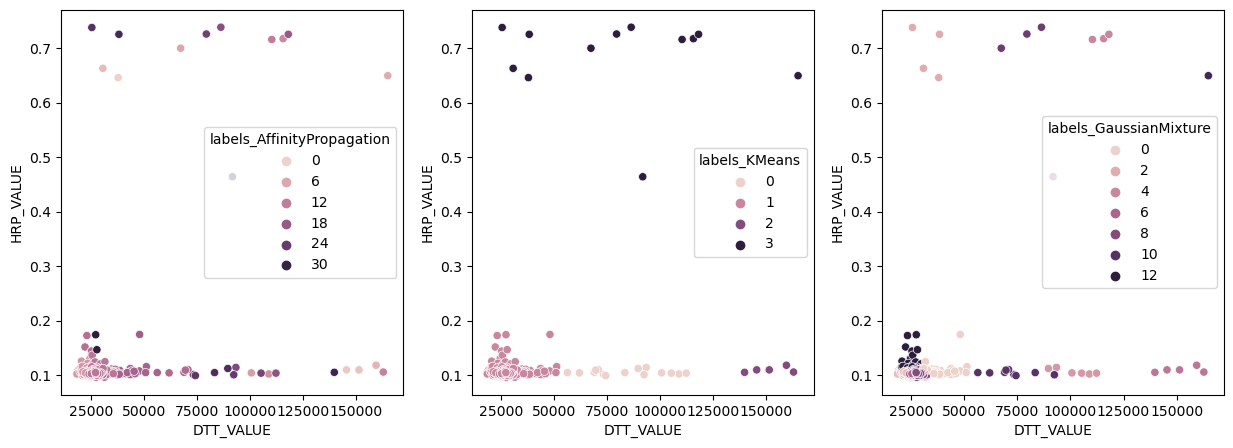

In [84]:
db_scores_merged = pd.concat([mean_value_merged, db_results], axis=1)

fig, ax = plt.subplots(1, 3, figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(db_scores_merged, x="DTT_VALUE", y="HRP_VALUE", hue=f"labels_{config['name']}", ax=subplt)

In [85]:
summarize_clustering(db_scores_merged)


==== AffinityPropagation CLUSTERING RESULT SUMMARY ====

Cluster 0: 1 compounds
	Mean DTT Value: 37919.0
	Mean HRP Value: 0.646
Cluster 1: 1 compounds
	Mean DTT Value: 145488.5
	Mean HRP Value: 0.1095
Cluster 2: 1 compounds
	Mean DTT Value: 151405.0
	Mean HRP Value: 0.1095
Cluster 3: 1 compounds
	Mean DTT Value: 30721.5
	Mean HRP Value: 0.663
Cluster 4: 1 compounds
	Mean DTT Value: 159470.5
	Mean HRP Value: 0.118
Cluster 5: 1 compounds
	Mean DTT Value: 164972.5
	Mean HRP Value: 0.6495
Cluster 6: 1 compounds
	Mean DTT Value: 67380.0
	Mean HRP Value: 0.7
Cluster 7: 1 compounds
	Mean DTT Value: 100683.5
	Mean HRP Value: 0.104
Cluster 8: 659 compounds
	Mean DTT Value: 22918.7344461305
	Mean HRP Value: 0.10544916540212443
Cluster 9: 1 compounds
	Mean DTT Value: 108894.0
	Mean HRP Value: 0.102
Cluster 10: 1 compounds
	Mean DTT Value: 115650.0
	Mean HRP Value: 0.7175
Cluster 11: 1 compounds
	Mean DTT Value: 162846.5
	Mean HRP Value: 0.1055
Cluster 12: 1 compounds
	Mean DTT Value: 110320.5
	M